In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import urllib.request, json
import os

from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import FunctionTransformer

### 1.1. Load the Data

In [37]:
df=pd.read_csv('../data/us_disaster_declarations.csv')

### 1.2. Clean States

In [38]:
# Clean states / remove territories 
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

df=df[df['state'].isin(mainland_states)]

### 1.3. Clean Incident Types

In [39]:
# List incident types to drop
disaster_drops=['Biological', 'Snowstorm', 'Fire', 'Severe Ice Storm', 'Tornado', 'Drought', 'Coastal Storm', 
                'Other', 'Freezing', 'Earthquake', 'Typhoon', 'Tropical Storm', 'Volcanic Eruption', 'Winter Storm',
                'Fishing Losses', 'Mud/Landslide', 'Dam/Levee Break', 'Toxic Substances', 'Tsunami', 'Chemical', 'Human Cause', 'Terrorist']

# Drop specified incident types
for d in disaster_drops:
    df=df[df.incident_type != d]

### Unused for now (combibe incident types)

In [ ]:
# List incident types to combine
common_disasters=['Severe Storm', 'Hurricane', 'Flood']

# Combine specified incidents into incident type 'winter weather'
for c in common_disasters:
    df.loc[df['incident_type'] == c, 'incident_type'] = 'Common Disasters'

In [5]:
# List incident types to combine
winter_weather=['Severe Ice Storm', 'Snowstorm', 'Freezing', 'Winter Storm']

# Combine specified incidents into incident type 'winter weather'
for w in winter_weather:
    df.loc[df['incident_type'] == w, 'incident_type'] = 'Winter Weather'

#result = df[df['incident_type'] == 'Winter Weather']
#print(result)

### 1.4. Date Encoding

In [40]:
# Create 'incident_dtm' column to convert 'incident_begin_date' obj to datetime
df['incident_dtm']=pd.to_datetime(df['incident_begin_date'], format='%Y-%m-%dT%H:%M:%SZ')

### 1.5. Clean Columns

In [12]:
# Remove unneeded columns

# Create subset_df with 'incident_dtm', 'incident_type', and 'state'
subset_df=df[['incident_dtm', 'incident_type', 'state']]

subset_df.set_index('incident_dtm', inplace=True)

subset_df.head()

,incident_type,state
incident_dtm,,
1953-05-29,Flood,LA
1953-06-06,Flood,MT
1953-06-11,Flood,IA
1953-06-19,Flood,TX
1953-10-22,Flood,FL


### 2.1. ARIMA Test

In [ ]:
# Monthly aggregation and "no disaster" feature
monthly_disasters = subset_df.resample('M').size()
monthly_disasters_df = monthly_disasters.to_frame(name='disaster_count')
monthly_disasters_df['no_disaster'] = monthly_disasters_df['disaster_count'].apply(lambda x: 1 if x == 0 else 0)

monthly_disasters_df.head()

In [17]:
# Train-test split
split_date = '2019-01-01'
train = monthly_disasters_df[:split_date]['disaster_count']
test = monthly_disasters_df[split_date:]['disaster_count']

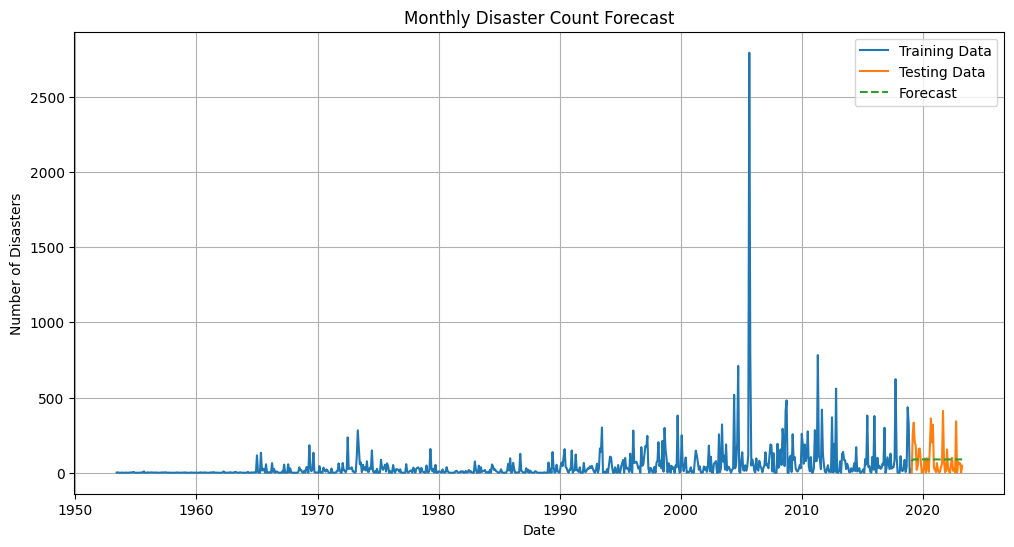

Root Mean Squared Error: 107.91252000062606


In [18]:
# ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Monthly Disaster Count Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Disasters')
plt.legend()
plt.grid()
plt.show()

# Evaluate model
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error: {rmse}")

### 2.2. Logistic Regression Test

In [41]:
# Select 3 most common disaster types
top_disasters_df=df['incident_type'].value_counts().head(3).index
df['top_disasters']=df['incident_type'].apply(lambda x: 1 if x in top_disasters_df else 0)

In [42]:
# Aggregate monthly disaster counts
df['month']=df['incident_dtm'].dt.to_period('M')
monthly_disasters=df.groupby('month')['top_disasters'].sum()

# Create a DataFrame with features
monthly_features=pd.DataFrame({'month': monthly_disasters.index.to_timestamp(), 'disaster_count': monthly_disasters.values})

# Create lagged features
monthly_features['lag_1']=monthly_features['disaster_count'].shift(1)
monthly_features['lag_2']=monthly_features['disaster_count'].shift(2)
monthly_features['lag_3']=monthly_features['disaster_count'].shift(3)

# Add a binary for disaster occurrence
monthly_features['disaster?']=monthly_features['disaster_count'].apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaN values created by lagging
monthly_features.dropna(inplace=True)

In [43]:
# Features and target variable
X = monthly_features[['lag_1', 'lag_2', 'lag_3']]
y = monthly_features['disaster?']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (477, 3), Testing data shape: (120, 3)


In [44]:
# Define transformers for sine and cosine
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Add 'month_int' column to represent months as integers
monthly_features['month_int'] = monthly_features['month'].dt.month

# Apply sine and cosine transformations
monthly_features['month_sin'] = sin_transformer(12).fit_transform(monthly_features[['month_int']])
monthly_features['month_cos'] = cos_transformer(12).fit_transform(monthly_features[['month_int']])

In [45]:
# Create a one-hot encoded DataFrame for the 'state' column
state_dummies = pd.get_dummies(df['state'], prefix='state')

# Merge the one-hot encoded states into the dataset
monthly_features = pd.concat([monthly_features, state_dummies], axis=1)

In [46]:
# Train logistic regression model
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)

In [ ]:
# Add predictions to the test set
results = X_test.copy()
results['actual'] = y_test
results['predicted'] = y_pred

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['actual'], label='Actual', marker='o')
plt.plot(results.index, results['predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Disaster Occurrence')
plt.xlabel('Time')
plt.ylabel('Disaster Occurrence (1 = Yes, 0 = No)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Computing the confusion matrix
disaster_cm = confusion_matrix(y_test, y_pred)

# Converting the confusion matrix to a DataFrame for easier visualization
cm_df = pd.DataFrame(disaster_cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plotting the confusion matrix
plt.figure(figsize=(5, 4)) 
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')